In [19]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [34]:
df=pd.read_csv('dataResearch.csv')
df

,SL.,Station,Year,Month,Date,Temperature (maximum),Temperature(minimum),Temperature(Average),Rainfall(mm),Humidity(percentage)
0,1,Sylhet (10705),1970,1,1/1/1970,23.90,11.37,17.635,62,76.52
1,2,Sylhet (10705),1970,2,1/2/1970,26.85,14.07,20.460,65,67.96
2,3,Sylhet (10705),1970,3,1/3/1970,29.92,17.86,23.890,60,66.26
3,4,Sylhet (10705),1970,4,1/4/1970,30.96,21.65,26.305,466,76.10
4,5,Sylhet (10705),1970,5,1/5/1970,31.22,23.08,27.150,851,80.84
...,...,...,...,...,...,...,...,...,...,...
631,632,Sylhet (10705),2022,8,1/8/2022,34.30,26.20,30.250,461,80.58
632,633,Sylhet (10705),2022,9,1/9/2022,33.28,25.57,29.425,744,84.63
633,634,Sylhet (10705),2022,10,1/10/2022,32.11,23.47,27.790,334,82.29
634,635,Sylhet (10705),2022,11,1/11/2022,31.32,19.55,25.435,0,73.53


In [35]:
# Load the data
df = pd.read_csv('dataResearch.csv', usecols=lambda column: column not in ['SL.', 'Station', 'Year', 'Month', 'Temperature (maximum)', 'Rainfall(mm)', 'Temperature(minimum)', 'Humidity(percentage)'])
df

,Date,Temperature(Average)
0,1/1/1970,17.635
1,1/2/1970,20.460
2,1/3/1970,23.890
3,1/4/1970,26.305
4,1/5/1970,27.150
...,...,...
631,1/8/2022,30.250
632,1/9/2022,29.425
633,1/10/2022,27.790
634,1/11/2022,25.435


In [36]:
# Assuming 'Date' is in string format, convert it to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [37]:
# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Temperature(Average)']])


In [42]:
# Convert the data to PyTorch tensors
data_tensor = torch.tensor(data_scaled, dtype=torch.float32).view(-1)

# Create sequences for input and target
seq_length = 10  # Adjust as needed
input_seq = []
target_seq = []

for i in range(len(data_tensor) - seq_length):
    seq = data_tensor[i:i + seq_length + 1]
    input_seq.append(seq[:-1].view(-1, 1))
    target_seq.append(seq[-1])

input_seq = torch.stack(input_seq)
target_seq = torch.stack(target_seq)


In [43]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


In [44]:
# Set hyperparameters
input_size = 1
hidden_size = 50  # Adjust as needed
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

In [45]:
# Instantiate the model, loss function, and optimizer
model = RNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(input_seq)
    optimizer.zero_grad()
    loss = criterion(outputs, target_seq)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([626])) that is different to the input size (torch.Size([626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.2683
Epoch [20/100], Loss: 0.0688
Epoch [30/100], Loss: 0.0628
Epoch [40/100], Loss: 0.0661
Epoch [50/100], Loss: 0.0639
Epoch [60/100], Loss: 0.0622
Epoch [70/100], Loss: 0.0620
Epoch [80/100], Loss: 0.0620
Epoch [90/100], Loss: 0.0620
Epoch [100/100], Loss: 0.0620


In [46]:
# Evaluate the model
model.eval()
with torch.no_grad():
    future = 365  # Predicting the next year (assuming daily data)
    pred_seq = data_tensor[-seq_length:].tolist()

    for _ in range(future):
        input_tensor = torch.tensor(pred_seq[-seq_length:], dtype=torch.float32).view(1, -1, 1)
        prediction = model(input_tensor)
        pred_seq.append(prediction.item())


In [49]:
# Inverse transform the scaled predictions
predicted_data = scaler.inverse_transform(np.array(pred_seq).reshape(-1, 1))
predicted_data

array([[26.85500028],
       [27.14499985],
       [27.22499996],
       [27.19499992],
       [29.94500025],
       [30.25000024],
       [29.42500038],
       [27.79000028],
       [25.43500006],
       [21.95499999],
       [25.55714951],
       [25.49945762],
       [25.45597094],
       [25.42435094],
       [25.40188784],
       [25.38051216],
       [25.36488899],
       [25.35566263],
       [25.35265185],
       [25.35547261],
       [25.36452332],
       [25.3633824 ],
       [25.36269338],
       [25.36229976],
       [25.36209138],
       [25.36199078],
       [25.36196523],
       [25.3619804 ],
       [25.36200755],
       [25.36203469],
       [25.36204747],
       [25.36203789],
       [25.3620331 ],
       [25.3620315 ],
       [25.3620307 ],
       [25.3620307 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25.3620315 ],
       [25

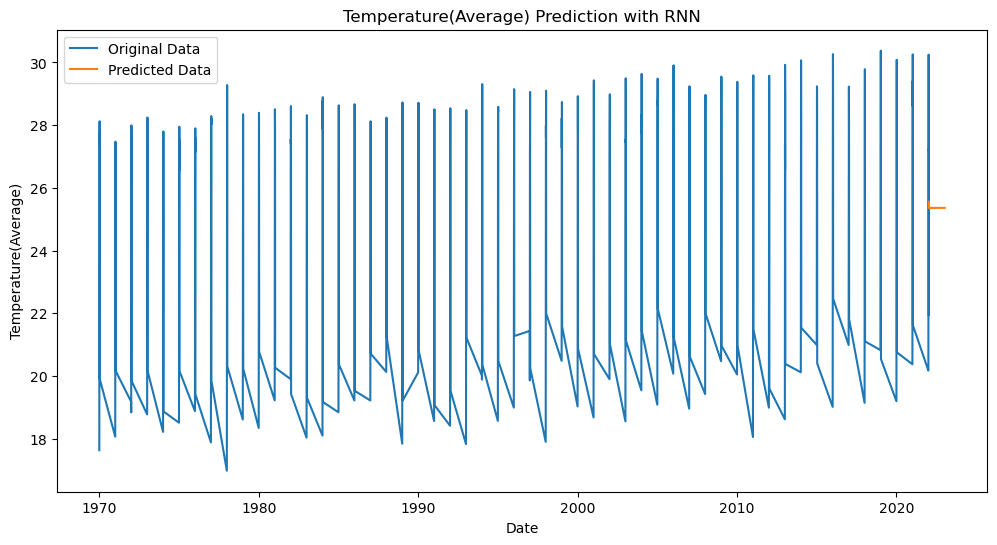

In [48]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature(Average)'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(1), periods=future), predicted_data[-future:], label='Predicted Data')
plt.title('Temperature(Average) Prediction with RNN')
plt.xlabel('Date')
plt.ylabel('Temperature(Average)')
plt.legend()
plt.show()